# _Narrative Tweet Exploration_

In [1]:
import pandas as pd
from pathlib import Path
import glob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
import umap
import pickle
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
%config InlineBackend.figure_format = 'retina'

In [2]:
#output_notebook()

In [3]:
def path_and_files():
    datapath = Path.cwd().parent / 'data' / 'misinformation_narratives'
    narrative_files = glob.glob(f'{datapath}/*/*.json')
    return datapath, narrative_files

In [10]:
def load_data(datapath, filename):
    df = pd.read_json(
        datapath / filename,
        lines=True
    )
    return df


def glob_load(filename):
    df = pd.read_json(
        filename,
        lines=True
    )
    df['narrative'] = str(filename.split('/')[8])
    return df

def sentimentscore(df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['full_text'].apply(
        lambda tweet: analyzer.polarity_scores(tweet)['compound']
    )
    return df


def cleandata(df):
    return df[['created_at', 'id_str', 'full_text', 'sentiment', 'narrative']]


def data_wrapper():
    datapath = path_to_data()
    filename = input('What is the filename?\n')
    df = load_data(datapath, filename)
    df = sentimentscore(df)
    df = cleandata(df)
    return df


#dfclean = data_wrapper().sort_values(by='sentiment')

In [11]:
def load_all_narratives(narrative_files):
    for file in narrative_files:
        df = pd.concat([glob_load(file) for file in narrative_files])
        df = sentimentscore(df)
        df = cleandata(df).reset_index(drop=True)
        return df

In [12]:
datapath, narrative_files = path_and_files()
df = load_all_narratives(narrative_files)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   created_at  60 non-null     datetime64[ns, UTC]
 1   id_str      60 non-null     int64              
 2   full_text   60 non-null     object             
 3   sentiment   60 non-null     float64            
 4   narrative   60 non-null     object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(2)
memory usage: 2.5+ KB


In [14]:
print(
    f'There are {len(df.narrative.unique())} narratives & include:\n\n{df.narrative.unique()}'
)

There are 6 narratives & include:

['zionist_plot' 'plandemic' 'bioweapon' 'hydroxychloroquine_cure'
 'deep_state_fauci' '5g_coronavirus']


### _Clean Text_

In [15]:
def emoji_replace(text):
    # first demojize text
    text = emoji.demojize(text) # use_aliases=True)
    regex = re.compile(r'(?<=:)(\S+)(?=:)', re.I)
    #text = punctuation_replace(new_text)
    #regex = re.compile(r"(:\S+:)", re.I)
    for item in regex.finditer(text):
        emojistr = str(item.group()) #.replace(r'_',''))
        #print(emojistr)
        #itemstring = item.group()
        text = re.sub(f'(?::)({emojistr})(?::)', str(' ' + emojistr.replace(r'_', '') + ' '),  text)
        
    return text

In [16]:
import re
import string
import emoji
from nltk.tokenize import RegexpTokenizer, regexp_tokenize

def newline_remove(text):
    regex = re.compile(r'\n+', re.I)
    text = regex.sub(' ', text)
    return text


def replace_coronavirus(text):
    regex = re.compile(r'(corona[\s]?virus)', re.I)
    return regex.sub('coronavirus', text)


def coronavirus_hashtags(text):
    regex = re.compile(r'#(coronavirus)\b', re.I)
    return regex.sub('xxhash coronavirus', text)


def replace_covid(text):
    regex = re.compile(r'(covid[-\s_]?19)|covid', re.I)
    return regex.sub('covid19', text)


def covid_hashtags(text):
    regex = re.compile(r'#(covid[_-]?(19))', re.I)
    return regex.sub('xxhash covid19', text)


def sarscov2_replace(text):
    regex = re.compile(r'(sars[-]?cov[-]?2)', re.I)
    return regex.sub(r'sarscov2', text)


def emoji_replace(text):
    # first demojize text
    text = emoji.demojize(text) # use_aliases=True)
    regex = re.compile(r'(?<=:)(\S+)(?=:)', re.I)
    for item in regex.finditer(text):
        emojistr = str(item.group())
        replacestr = str(' xxemoji ' + emojistr.replace(r'_', '') + ' ')
        pattern = r"(?::)" + re.escape(emojistr) + r"(?::)"
        # r'(?::)({emojistr})(?::)'
        text = re.sub(pattern, replacestr,  text)
    return text


def twitterpic_replace(text):
    regex = re.compile(r"pic.twitter.com/\w+", re.I)
    return regex.sub(" xxpictwit ", text)


def youtube_replace(text):
    regex = re.compile(r"(https://youtu.be/(\S+))|(https://www.youtube.(\S+))", re.I)
    return regex.sub(" xxyoutubeurl ", text)


def url_replace(text):
    regex1 = re.compile(r'(?:http|ftp|https)://(\S+)|(?:www)\.\S+\b', re.I)
    regex2 = re.compile(r'((\b\S+)\.(?:[a-z+]{2,3}))', re.I)
    text = regex1.sub(' xxurl ', text)
    text = regex2.sub(' xxurl ', text)
    return text


def punctuation_replace(text):
    # put spaces between punctuation
    PUNC = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~…–”“’'
    punct = r"[" + re.escape(PUNC) + r"]"
    text = re.sub("(?<! )(?=" + punct + ")|(?<=" + punct + ")(?! )", r" ", text)
    text = re.sub(r"[^\w\s]", 'xxpunc', text) # could replace with xxpunc
    # remove any extra whitespace
    text = re.sub(r'[ ]{2,}',' ',text)
    return text


def clean_wrapper(text, nltk_tokenize=False, punc_replace=False):
    PUNC = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~…–”“’'
    # removes newline characters from text
    text = newline_remove(text)
    # standardizes all instances of coronavirus in text
    text = replace_coronavirus(text)
    # replaces instances of #coronavirus with special token, xxhashcoronavirus
    text = coronavirus_hashtags(text)
    # standardizes all instances of covid19
    text = replace_covid(text)
    # replaces instances of #covid19 with special token, xxhashcovid19
    text = covid_hashtags(text)
    # standardizes SARS-Cov-2 to sarscov2
    text = sarscov2_replace(text)
    # removes hashtag characters
    text = text.replace(r'#', 'xxhash ')
    # removes @ character
    text = text.replace(r'@', 'xxmention ')
    # replace emojies with special token xxemoji
    text = emoji_replace(text)
    # replace pic.twitter.com links with special token, xxpictwit
    text = twitterpic_replace(text)
    # replace YouTube links with special token, xxyoutubeurl
    text = youtube_replace(text)
    # replace other URLs with special token, xxurl
    text = url_replace(text)
    # if nltk_tokenize parameter True, then use regexp_tokenize from nltk library
    if nltk_tokenize == True:
        tokens = RegexpTokenizer('\s+', gaps=True).tokenize(text)
        text = ' '.join([''.join([char for char in word if char not in PUNC]) for word in tokens])
    # if punc_replace set to True, replace all punctuations
    if punc_replace == True:
        text = punctuation_replace(text)
    # remove any unnecessary whitespace
    text = re.sub(r'[ ]{2,}',' ',text)
    return text.strip()

In [18]:
df['processed_tweet'] = df['full_text'].apply(clean_wrapper)

In [19]:
df.to_json('playground_data/narratives_june6.json', orient='columns')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   created_at       60 non-null     datetime64[ns, UTC]
 1   id_str           60 non-null     int64              
 2   full_text        60 non-null     object             
 3   sentiment        60 non-null     float64            
 4   narrative        60 non-null     object             
 5   processed_tweet  60 non-null     object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(3)
memory usage: 2.9+ KB


### _Embeddings --> Generated via Google Colab_

### _UMAP_

In [86]:
Path.cwd().parent

PosixPath('/Users/jairesearch/Documents/SharpestMinds/covid_disinfo_detect')

In [12]:
def load_embeddings():
    path = Path().cwd() / 'playground_data'
    filename = input('What is the file name?\n')
    pkl_file = open(
        path / filename, 'rb'
    )
    X = pickle.load(pkl_file)
    return X

In [15]:
X = load_embeddings()

What is the file name?
 narratives_june2_embeddings.pkl


In [16]:
def apply_umap(X):
    dr = umap.UMAP(n_components=2, metric='cosine')
    dr.fit(X)
    X_dr = dr.transform(X)
    return X_dr

In [17]:
def plot_reduced_2D(X_dr, dr_type):
    _, ax = plt.subplots(figsize=(10,10))
    ax.scatter(X_dr[:,0],X_dr[:,1], alpha=0.8)
    ax.set_title(dr_type+' with 2 components')
    plt.show()

/Users/jairesearch/opt/anaconda3/envs/SM_test/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


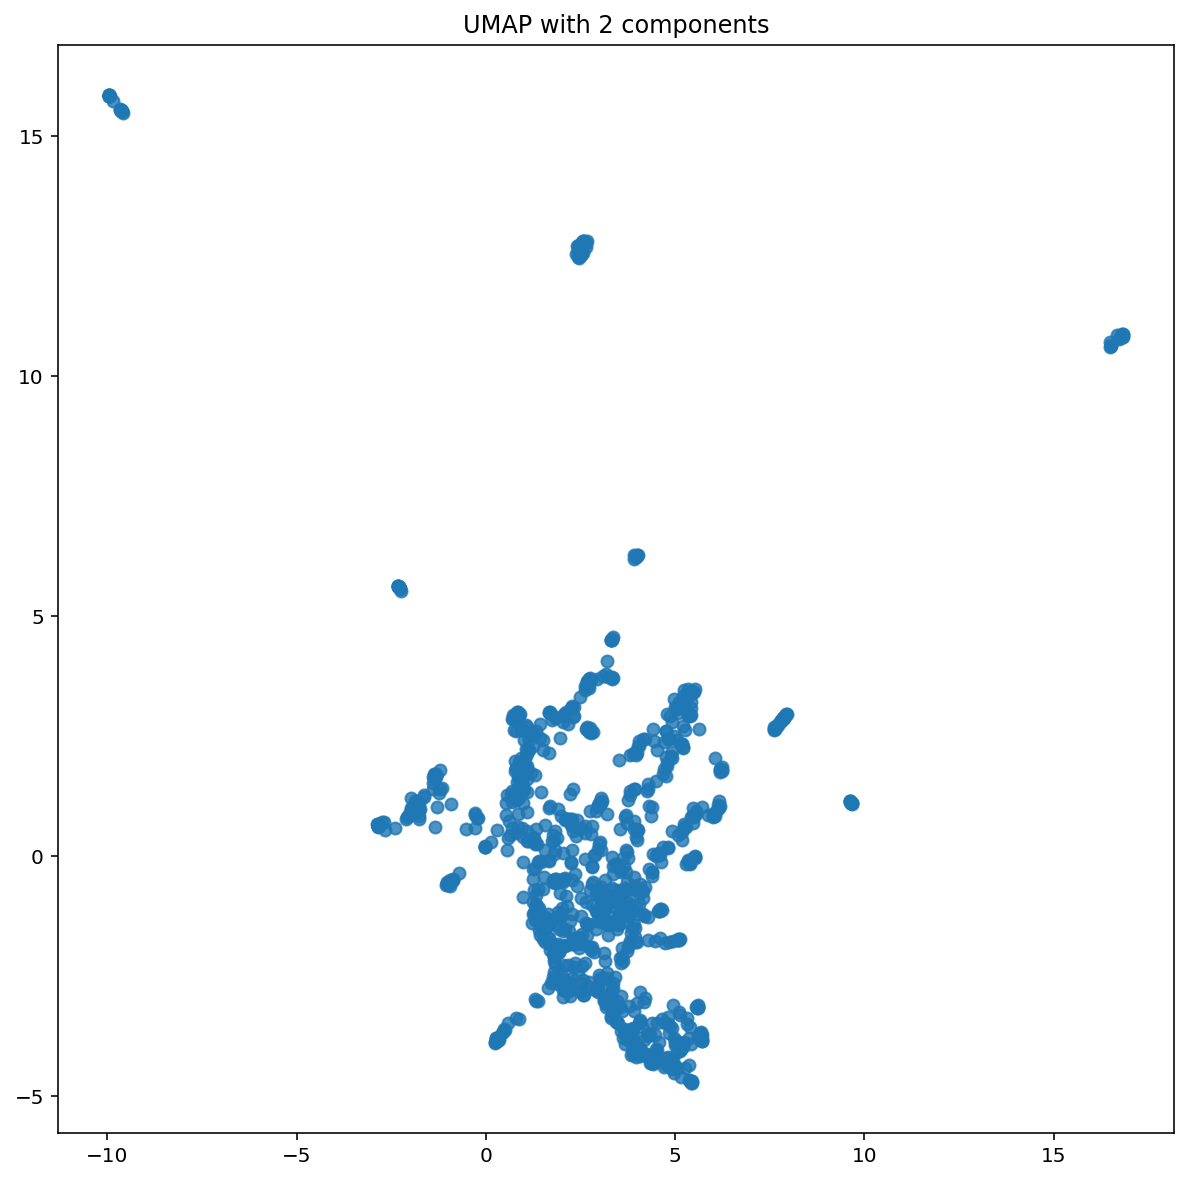

In [18]:
X_dr = apply_umap(X)
plot_reduced_2D(X_dr, 'UMAP')

## _Bokeh_

In [24]:
tweet_embed_df = pd.DataFrame(X_dr, columns=('x', 'y'))
tweet_embed_df.head()

,x,y
0,4.451138,-4.292727
1,4.081532,-3.990924
2,4.057976,-3.479686
3,5.718941,-3.844630
4,-2.239028,5.532303


In [28]:
tweet_embed_df['tweet'] = [str(x) for x in df['tweet']]
tweet_embed_df['narrative'] = [str(x) for x in df['narrative']]

In [29]:
tweet_embed_df.head()

,x,y,tweet,narrative
0,4.451138,-4.292727,JIM BAKKER - CONMAN - has been pushing a subst...,silver_cure
1,4.081532,-3.990924,Hard no. The same way I wouldn’t buy Silver So...,silver_cure
2,4.057976,-3.479686,TELEVANGELIST SELLS $125 'SILVER SOLUTION' AS ...,silver_cure
3,5.718941,-3.844630,A conspiracy theorist who scammed people with ...,silver_cure
4,-2.239028,5.532303,"#Blockchain - ""the silver bullet solution for ...",silver_cure
